In [1]:
import numpy as np
import matplotlib.pyplot as plt
from probDE.utils.utils import zero_pad
from probDE.utils.utils import root_gen
from probDE.Kalman.kalman_initial_draw import kalman_initial_draw
from probDE.Kalman import kalman_ode_higher
from probDE.Kalman.higher_mvncond import higher_mvncond
#from kalman_ode_higher_cy import kalman_ode_higher as kalman_ode_higher_cy

In [2]:
%load_ext Cython

In [3]:
%%cython
from libc.math cimport sin
import numpy as np
cimport numpy as np
def ode_fun(np.ndarray[np.double_t, ndim=1] x_t, double t):
    return sin(2*t) - x_t[0]

In [4]:
def chk_exact_x(t):
    return (-3*cos(t) + 2*sin(t) - sin(2*t))/3

def chk_exact_x1(t):
    return (-2*cos(2*t) + 3*sin(t) + 2*cos(t))/3

In [8]:
N = 50
q = 2
p = q+2
tmin = 0
tmax = 10
delta_t = np.array([(tmax-tmin)*1/N])
w = np.array([0. , 0., 1.])
wgt_meas = zero_pad(w, p)
x0 = np.array([-1., 0., 0.])
x0 = np.array([-1.0, 0.0, ode_fun(x0, 0)]) #Initial state
r0 = 500
sigma = 0.5
roots = root_gen(r0, p) #Generate roots to draw x^{(3)}_0
x_0 = kalman_initial_draw(roots, sigma, x0, p)
wgt_state, var_state = higher_mvncond(delta_t, roots, sigma) 
mu_state = np.zeros(p)

Yn, Yn_chk_mean, Yn_chk_var = kalman_ode_higher(ode_fun, x_0, tmin, tmax, N-1, wgt_state, mu_state, var_state, wgt_meas)

In [9]:
%%cython
import numpy as np
cimport numpy as np
cdef bint boolean_variable = True
def rand_mat(int n, int p, bint pd=True):
    cdef np.ndarray[np.double_t, ndim=2] V = np.zeros((p, n), order='F')
    V[:] = np.random.randn(p, n)
    if (p == n) and pd:
        V[:] = np.matmul(V, V.T)
    return V

In [10]:
z_state_sim = rand_mat(2*N, p)

In [11]:
Yn2, Yn_chk_mean2, Yn_chk_var2 = kalman_ode_higher_cy(ode_fun, x_0, tmin, tmax, N-1, wgt_state, mu_state, var_state, wgt_meas, z_state_sim)

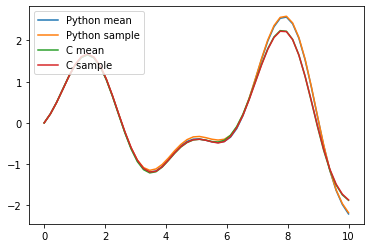

In [12]:
tseq = np.linspace(tmin, tmax, N)
plt.plot(tseq, Yn_chk_mean[:, 1], label = 'Python mean')
plt.plot(tseq, Yn[:, 1], label = 'Python sample')
plt.plot(tseq, Yn_chk_mean2[1], label = 'C mean')
plt.plot(tseq, Yn2[1], label = 'C sample')
plt.legend(loc='upper left')

## Python, Cython, Odeint Timings

In [13]:
py = %timeit -o Yn, Yn_chk_mean, Yn_chk_var = \
    kalman_ode_higher(ode_fun, x_0, tmin, tmax, N-1, wgt_state, mu_state, var_state, wgt_meas)

20.2 ms ± 3.4 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
cy = %timeit -o Yn2, Yn_chk_mean2, Yn_chk_var2 = \
    kalman_ode_higher_cy(ode_fun, x_0, tmin, tmax, N-1, wgt_state, mu_state, var_state, wgt_meas, z_state_sim)

3.52 ms ± 409 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
py.average/cy.average

5.736607588907907

In [16]:
from scipy import integrate
from math import sin
def f(x_t, t):
    return [x_t[1], sin(2*t) - x_t[0]]

In [17]:
ode = %timeit -o ode = integrate.odeint(f, [-1, 0], tseq)
cy.average/ode.average

641 µs ± 89.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


5.4894355325783675

## Python to Cython Comparisons of `fun` and `rand_mat`

In [18]:
def rand_mat_py(n, p=None, pd=True):
    """Generate a random matrix, positive definite if `pd = True`."""
    if p is None:
        p = n
    V = np.zeros((p, n), order='F')
    V[:] = np.random.randn(p, n)
    if (p == n) & pd:
        V[:] = np.matmul(V, V.T)
    return V

In [19]:
%timeit rand_mat(2*N, p)

16.8 µs ± 1.3 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [20]:
%timeit rand_mat_py(2*N, p)

13 µs ± 92.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [21]:
def ode_fun_py(x_t, t):
    return sin(2*t) - x_t[0]

In [22]:
%timeit ode_fun(x_0, 0)

463 ns ± 4.01 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [23]:
%timeit ode_fun_py(x_0, 0)

418 ns ± 3.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
